In [153]:
# Imports
import decimal
import copy
from typing import Dict
import collections

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas
import plotly.express as px

import db
import classes
import constants

In [116]:
# ZKLend Events Data 
connection = db.establish_connection()

# Load all Zklend events.
zklend_events = pandas.read_sql(
    sql = 
    f"""
    SELECT
        *
    FROM
        starkscan_events
    WHERE
        from_address='{constants.Protocol.ZKLEND.value}'
    AND
        key_name IN ('Deposit', 'Withdrawal', 'CollateralEnabled', 'CollateralDisabled', 'Borrowing', 'Repayment', 'Liquidation', 'AccumulatorsSync')
    ORDER BY
        block_number ASC, id;
    """,
    con = connection,
)

# Close the connection.
connection.close()

zklend_events.set_index('id', inplace = True)

/tmp/ipykernel_367422/2066804722.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  zklend_events = pandas.read_sql(


In [117]:
# Iterate over ordered events to obtain the final state of each user.
state = State()
prices = Prices()
for _, event in zklend_events.iterrows():
    state.process_event(event = event)

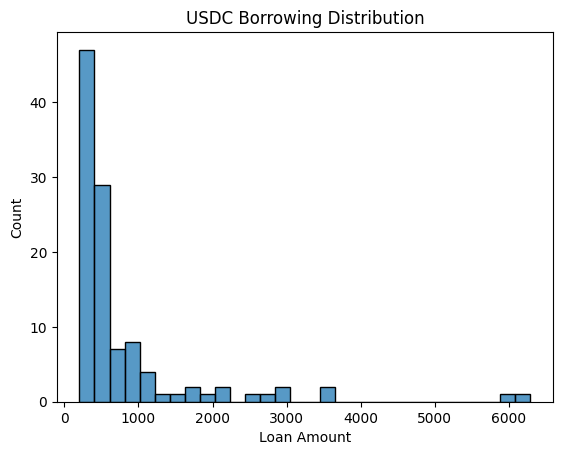

In [101]:
# USDC Tokens 
user_borrowings = []
for user_state in state.user_states.values(): 
    borrowings = user_state.token_states['USDC'].borrowings * prices.prices['USDC'] / 10**constants.get_decimals('USDC')
    if borrowings > 200: 
        user_borrowings.append(borrowings)
sns.histplot(data=user_borrowings);
plt.title('USDC Borrowing Distribution');
plt.xlabel('Loan Amount');

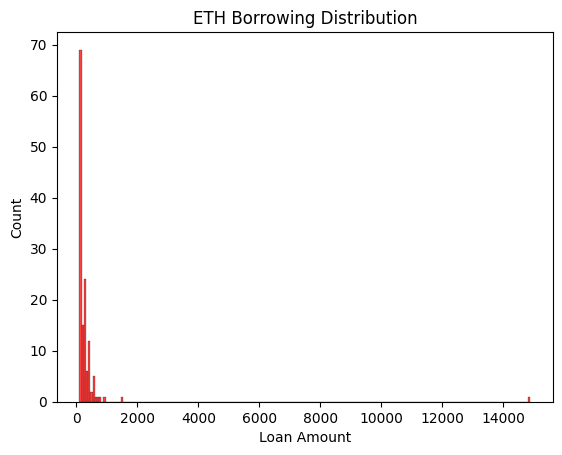

In [102]:
# ETH Tokens
user_borrowings = []
for user_state in state.user_states.values(): 
    borrowings = user_state.token_states['ETH'].borrowings * prices.prices['ETH'] / 10**constants.get_decimals('ETH')
    if borrowings > 100: 
        user_borrowings.append(borrowings)
sns.histplot(data=user_borrowings, color = 'red');
plt.title('ETH Borrowing Distribution');
plt.xlabel('Loan Amount');

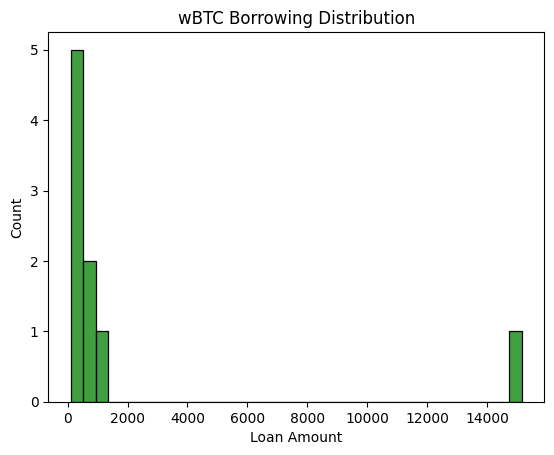

In [104]:
# wBTC Tokens 
user_borrowings = []
for user_state in state.user_states.values(): 
    borrowings = user_state.token_states['wBTC'].borrowings * prices.prices['wBTC'] / 10**constants.get_decimals('wBTC')
    if borrowings > 100: 
        user_borrowings.append(borrowings)
sns.histplot(data=user_borrowings, color = 'green');
plt.title('wBTC Borrowing Distribution');
plt.xlabel('Loan Amount');

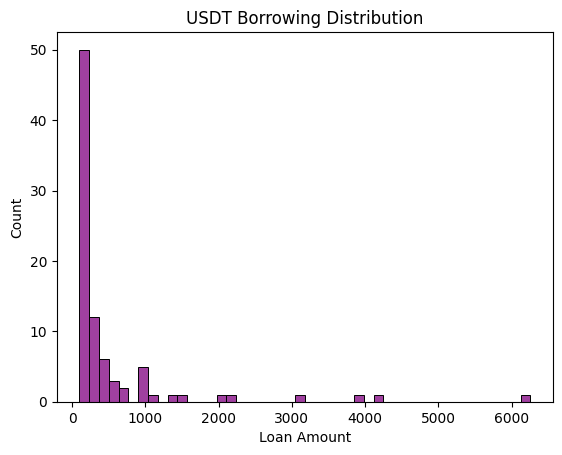

In [105]:
# USDT Tokens 
user_borrowings = []
for user_state in state.user_states.values(): 
    borrowings = user_state.token_states['USDT'].borrowings * prices.prices['USDT'] / 10**constants.get_decimals('USDT')
    if borrowings > 100: 
        user_borrowings.append(borrowings)
sns.histplot(data=user_borrowings, color = 'purple');
plt.title('USDT Borrowing Distribution');
plt.xlabel('Loan Amount');

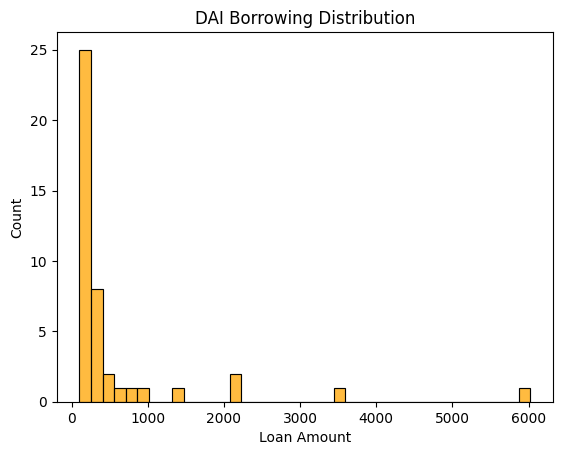

In [107]:
# DAI Tokens 
user_borrowings = []
for user_state in state.user_states.values(): 
    borrowings = user_state.token_states['DAI'].borrowings * prices.prices['DAI'] / 10**constants.get_decimals('DAI')
    if borrowings > 100: 
        user_borrowings.append(borrowings)
sns.histplot(data=user_borrowings, color = 'orange');
plt.title('DAI Borrowing Distribution');
plt.xlabel('Loan Amount');

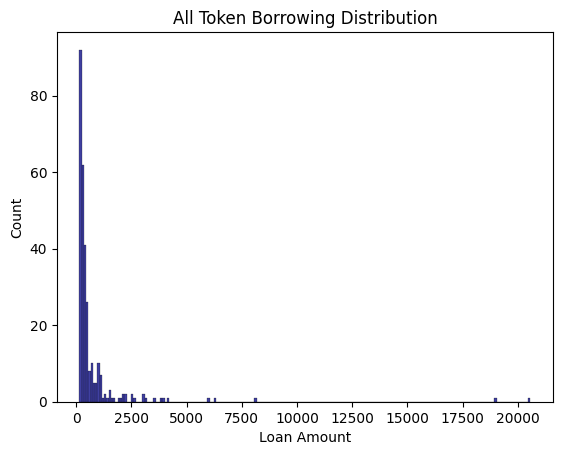

In [118]:
# ALL Tokens    
user_borrowings = []
for token in constants.symbol_decimals_map.keys():  
    for user_state in state.user_states.values(): 
        borrowings = user_state.token_states[token].borrowings * prices.prices[token] / 10**constants.get_decimals(token)
        if borrowings > 150: 
            user_borrowings.append(borrowings)
sns.histplot(data=user_borrowings, color = 'navy');
plt.title('All Token Borrowing Distribution');
plt.xlabel('Loan Amount');

In [157]:
# Comparative Token Distribution

tmp = [
    {'token': token, 'borrowings': user_state.token_states[token].borrowings * prices.prices[token] / 10**constants.get_decimals(token)}
    for user_state in state.user_states.values()
    for token in constants.symbol_decimals_map.keys()
]

token_data = pandas.DataFrame(tmp)
token_data['borrowings'] = token_data['borrowings'].astype(float)
token_data = token_data[token_data['borrowings'] > 100]
fig = px.histogram(token_data, x='borrowings', color='token', title='Distribution of all Token Borrowings')
fig.show()

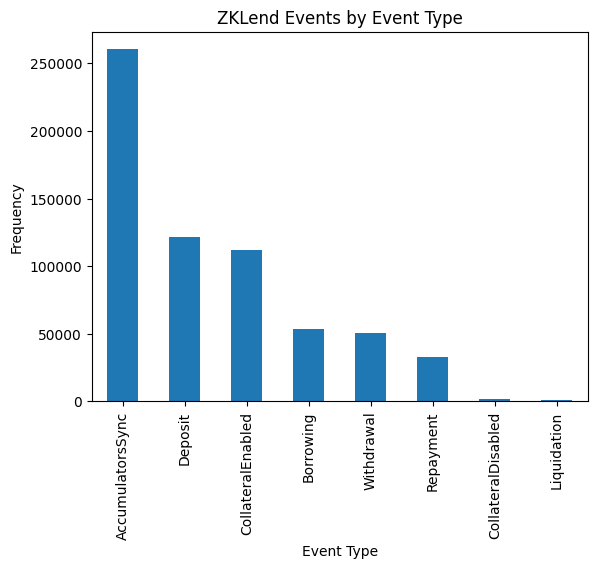

In [95]:
# ALL ZKLend Events Visualization 
event_counts = zklend_events['key_name'].value_counts()
event_counts.plot(kind='bar');
plt.title("ZKLend Events by Event Type");
plt.xlabel("Event Type");
plt.ylabel("Frequency");